# Attention : 
# Faire "File -> Save a copy in Drive" avant de commencer à modifier le notebook, sinon vos modifications ne seront pas sauvegardées.


In [2]:
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP3-4/TP3-4.zip
!unzip -j TP3-4.zip

--2021-12-04 22:55:45--  http://webia.lip6.fr/~dancette/deep-learning/assets/TP3-4/TP3-4.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13421167 (13M) [application/zip]
Saving to: ‘TP3-4.zip’

TP3-4.zip           100%[===================>]  12.80M  8.55MB/s    in 1.5s    

2021-12-04 22:55:47 (8.55 MB/s) - ‘TP3-4.zip’ saved [13421167/13421167]

Archive:  TP3-4.zip
  inflating: tme5.py                 
  inflating: mnist.mat               
  inflating: circles.py              
  inflating: circles.mat             


In [3]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'tme5.py'

# Partie 1 : Forward et Backward manuels

In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    
    Wh = torch.randn((nx, nh)) * 0.3
    Wy = torch.randn((nh, ny)) * 0.3
    bh = torch.randn((1, nh)) * 0.3
    by = torch.randn((1, ny)) * 0.3
    
    params["Wh"] = Wh
    params["Wy"] = Wy
    params["bh"] = bh
    params["by"] = by
    
    return params

In [ ]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}

    Wh = params.get('Wh')
    Wy = params.get('Wy')
    bh = params.get('bh')
    by = params.get('by')

    bh = bh[0,:]
    bh = bh.repeat(bsize, 1)
    by = by[0,:]
    by = by.repeat(bsize, 1)
    params["bh"] = bh
    params["by"] = by

    htilde = X @ Wh + bh
    h = torch.tanh(htilde)
    ytilde = h @ Wy + by
    yhat = torch.nn.functional.softmax(ytilde, dim=1)
    
    outputs["X"] = X
    outputs["htilde"] = htilde
    outputs["h"] = h
    outputs["ytilde"] = ytilde
    outputs["yhat"] = yhat

    return outputs['yhat'], outputs

In [ ]:
def loss_accuracy(Yhat, Y):

    _, indsY = torch.max(Y, 1)
    predYhat = (Yhat.gather(1, indsY.view(-1,1)))
    values, ind = torch.max(Yhat, 1)

    L = -torch.sum(torch.log(predYhat))
    acc = torch.mean(torch.eq(input=predYhat, other=values.unsqueeze(1)).float())*100

    return L, acc

In [ ]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    Wh = params.get('Wh')
    Wy = params.get('Wy')
    bh = params.get('bh')
    by = params.get('by')

    X = outputs.get('X')
    h = outputs.get('h')
    htilde = outputs.get('htilde')
    yhat = outputs.get('yhat')
    
    g1 = (yhat-Y)
    g2 = (g1 @ Wy.T *(1-h**2)).T

    gradWy = g1.T @ h
    gradby = bsize * g1.T

    gradWh = g2 @ X
    gradbh = bsize*g2
    
    grads["Wy"] = gradWy / bsize
    grads["Wh"] = gradWh / bsize
    grads["by"] = gradby / bsize
    grads["bh"] = gradbh / bsize
    
    return grads

In [ ]:
def sgd(params, grads, eta):

    Wh = params.get('Wh')
    Wy = params.get('Wy')
    bh = params.get('bh')
    by = params.get('by')

    gradWh = grads.get("Wh")
    gradWy = grads.get("Wy")
    gradbh = grads.get("bh")
    gradby = grads.get("by")

    Wh = Wh - eta * gradWh.T
    Wy = Wy - eta * gradWy.T
    bh = bh - eta * gradbh.T
    by = by - eta * gradby.T

    params["Wh"] = Wh
    params["Wy"] = Wy
    params["bh"] = bh
    params["by"] = by    

    return params

## Algorithme global d'apprentissage (manuel)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        
        Yhat, outputs = forward(params, X)
        loss, acc = loss_accuracy(Yhat, Y)
        grads = backward(params, outputs, Y)
        params = sgd(params, grads, eta)

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Partie 2 : Simplification du backward avec `torch.autograd`



In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    params["Wh"] = torch.randn(nx, nh, requires_grad=True) 
    params["Wy"] = torch.randn(nh, ny, requires_grad=True)
    params["bh"] = torch.randn(1, nh, requires_grad=True)
    params["by"] = torch.randn(1, ny, requires_grad=True)

    return params

La fonction `forward` est inchangée par rapport à la partie précédente. 

La fonction `backward` n'est plus utilisée grâce à l'autograd. 

In [ ]:
def sgd(params, eta):

    with torch.no_grad():      
      
      params['Wh'] -= eta * params['Wh'].grad
      params['Wy'] -= eta * params['Wy'].grad
      params['bh'] -= eta * params['bh'].grad
      params['by'] -= eta * params['by'].grad

      params['Wh'].grad.zero_()
      params['Wy'].grad.zero_()
      params['bh'].grad.zero_()
      params['by'].grad.zero_()

    return params

## Algorithme global d'apprentissage (avec autograd)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        Yhat, outputs = forward(params, X)
        L, _ = loss_accuracy(Yhat, Y)

        params['bh'].retain_grad()
        params['by'].retain_grad()

        L.backward()

        params = sgd(params, eta)


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() est utilisé pour détacher les predictions du graphes de calcul autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Partie 3 : Simplification du forward avec `torch.nn`

`init_params` et `forward` sont supprimés et remplacés par une fonction `init_model` qui déclare l'architecture du modèle et la loss.

In [4]:
def init_model(nx, nh, ny):

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        )
    
    loss = torch.nn.CrossEntropyLoss()

    return model, loss

In [5]:
def loss_accuracy(loss, Yhat, Y):

    _, indsY = torch.max(Y, 1)
    predYhat = (Yhat.gather(1, indsY.view(-1,1)))
    values, ind = torch.max(Yhat, 1)

    L = loss(Yhat, indsY)
    acc = torch.mean(torch.eq(input=predYhat, 
                              other=values.unsqueeze(1)).float())*100

    return L, acc

In [ ]:
def sgd(model, eta):

    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
        model.zero_grad()

    return model

## Algorithme global d'apprentissage (avec autograd et les couches `torch.nn`)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
  
        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()
        model = sgd(model, eta)

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  
    Ygrid = torch.nn.Softmax()(Ygrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain*100, acctest, Ltest*100)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain*100)
    curves[3].append(Ltest*100)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train *100")
plt.plot(curves[3], label="loss test *100")
plt.legend()
plt.show()

# Partie 4 : Simplification de SGD avec `torch.optim`

In [6]:
def init_model(nx, nh, ny, eta):

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        )
    
    loss = torch.nn.CrossEntropyLoss()

    optim = torch.optim.SGD(model.parameters(), lr=eta)

    return model, loss, optim

La fonction `sgd` est supprimée. À la place, on fera un appel à `optim.zero_grad()` avant de faire le backward et à `optim.step()` après le backward. 

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

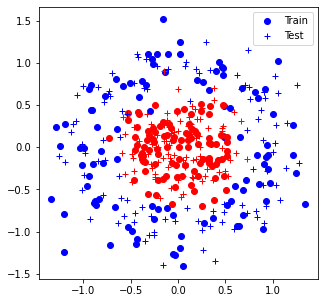

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
     

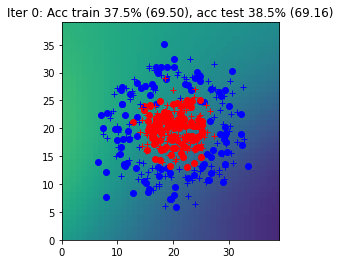

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

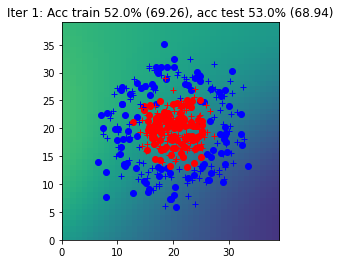

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

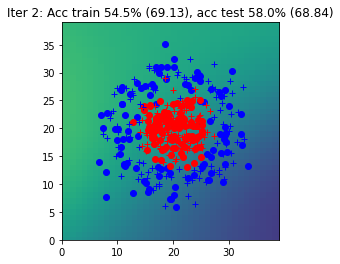

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
     

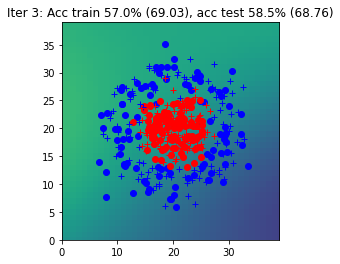

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
     

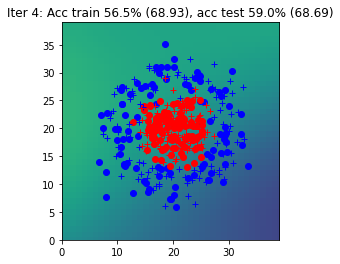

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
     

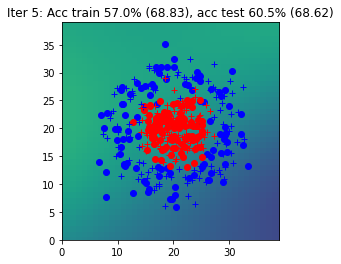

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
     

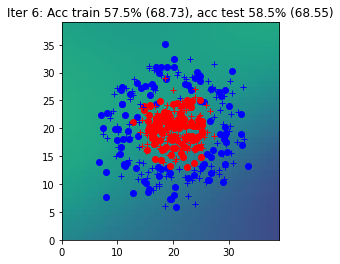

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
     

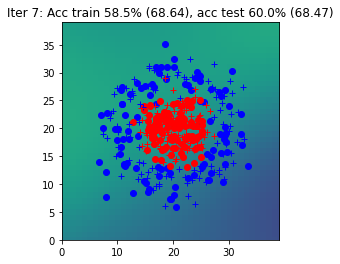

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

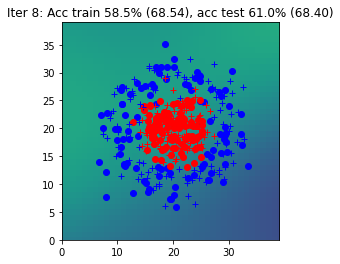

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
     

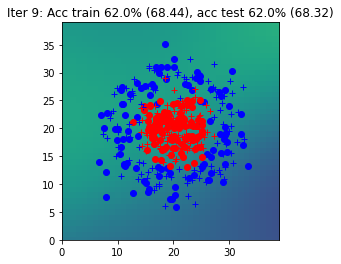

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
     

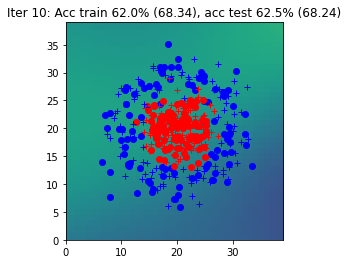

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
     

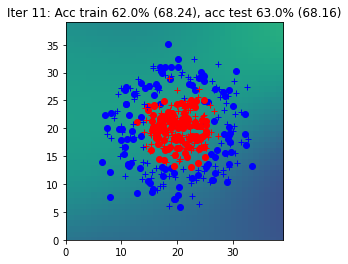

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
     

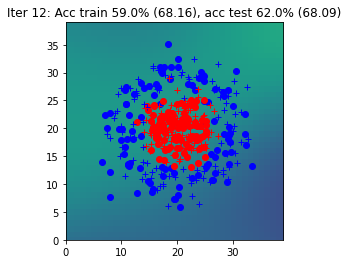

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
     

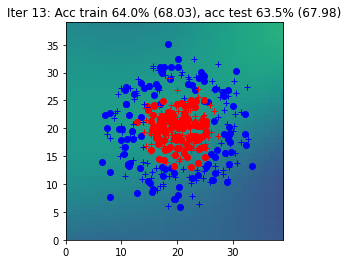

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
     

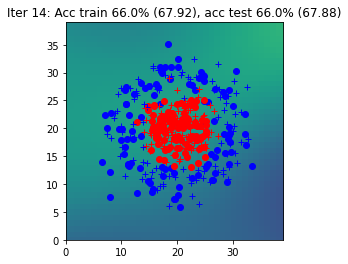

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

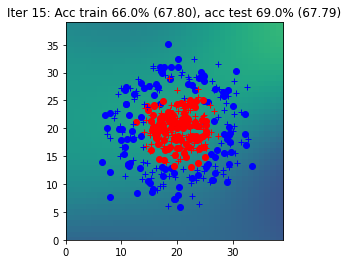

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
     

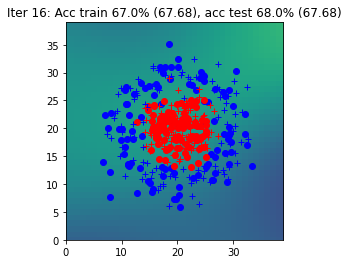

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

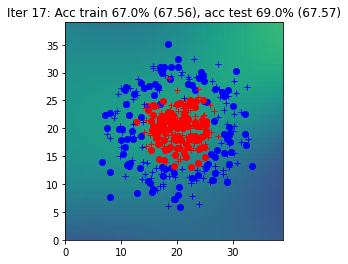

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
     

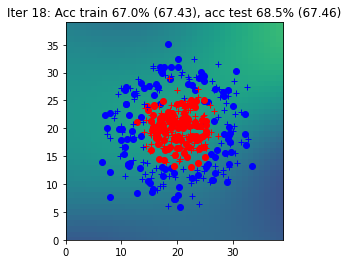

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
     

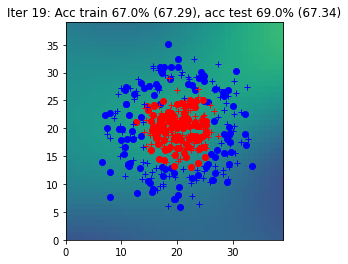

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
     

KeyboardInterrupt: ignored

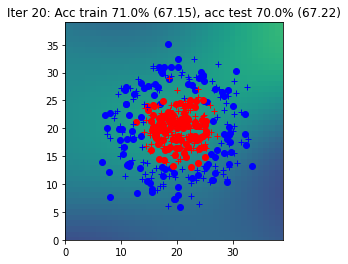

In [8]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
  
        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        optim.zero_grad()
        L.backward()
        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain*100, acctest, Ltest*100)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain*100)
    curves[3].append(Ltest*100)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train *100")
plt.plot(curves[3], label="loss test *100")
plt.legend()
plt.show()

# Partie 5 : MNIST

Reprendre le code d'entraînement précédent en l'appliquant au dataset MNIST.

In [9]:
def loss_accuracy(loss, Yhat, Y):

    _, indsY = torch.max(Y, 1)
    predYhat = (Yhat.gather(1, indsY.view(-1,1)))
    values, ind = torch.max(Yhat, 1)

    L = loss(Yhat, indsY)
    acc = torch.mean(torch.eq(input=predYhat, other=values.unsqueeze(1)).float())*100

    return L, acc

In [10]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.007

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N//Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        print(Y)
        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        optim.zero_grad()
        L.backward()
        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain*200, acctest, Ltest*200)
    print(title) 

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain*200)
    curves[3].append(Ltest*200)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train *200")
plt.plot(curves[3], label="loss test *200")
plt.legend()
plt.show()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

KeyboardInterrupt: ignored

# Partie 6: Bonus: SVM


Entrainez un modèle SVM sur le jeu de data Circles.
Le code à remplir est indiqué par des commentaires.


Idées : 
- Essayer d'abord un SVM linéaire (sklearn.svm.LinearSVC dans scikit-learn). Est-ce que cela fonctionne bien ? Pourquoi
- Essayer d'autres kernels (possible avec sklearn.svm.SVC).
Lequel fonctionne le mieux ? Pourquoi ?
- Est-ce que le paramètre C de régularisation à un impact ? Pourquoi ?

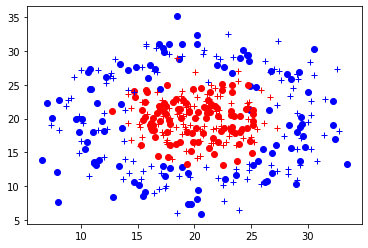

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_data(data):
      Xtrain = data.Xtrain.numpy()
      Ytrain = data.Ytrain[:, 0].numpy()
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

plot_data(data)

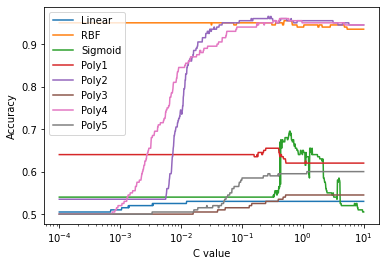

In [ ]:
import sklearn.svm
import numpy as np

LC = np.logspace(-4, 1, 1000)
Lacc = [[], [], [], [], [], [], [], []]
Labels = ['Linear', 'RBF', 'Sigmoid', 'Poly1', 'Poly2', 'Poly3', 'Poly4', 'Poly5']

Lsvm = [sklearn.svm.LinearSVC(C=1),
        sklearn.svm.SVC(C=1, kernel='rbf'),
        sklearn.svm.SVC(C=1, kernel='sigmoid'),
        sklearn.svm.SVC(C=1, kernel='poly', degree=1),
        sklearn.svm.SVC(C=1, kernel='poly', degree=2),
        sklearn.svm.SVC(C=1, kernel='poly', degree=3),
        sklearn.svm.SVC(C=1, kernel='poly', degree=4),
        sklearn.svm.SVC(C=1, kernel='poly', degree=5)
        ]

i = 0
for svm in Lsvm:
  for C in LC:
    svm.C = C
    svm.fit(Xtrain, Ytrain)
    Ytest_pred = svm.predict(Xtest)
    accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
    Lacc[i].append(accuracy)
  
  plt.xscale("log")
  plt.plot(LC, Lacc[i], label = Labels[i])
  i += 1

plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()


In [ ]:
## Entrainement du SVM

#svm = sklearn.svm.LinearSVC(C=1)
svm = sklearn.svm.SVC(C=1, kernel='linear', degree=5)

svm.fit(Xtrain, Ytrain)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Accuracy : 62.00


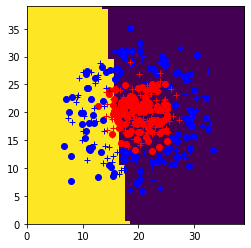

In [ ]:
## Affichage des résultats

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)